In [1]:
import numpy as onp

import jax.numpy as jnp
from jax import random
from jax import jit, grad, vmap, value_and_grad
from jax import lax
from jax import ops

from jax.config import config
config.update("jax_enable_x64", True)

from jax_md import space, smap, energy, minimize, quantity, simulate, partition, util
NeighborListFormat = partition.NeighborListFormat

from functools import partial
import time
from typing import List, Dict, Tuple, Callable, Optional

f32 = jnp.float32
f64 = jnp.float64
Array = jnp.ndarray

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

def format_plot(x, y):  
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 0.7)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def calculate_bond_data(displacement_or_metric, R, dr_cutoff, species=None):
  if( not(species is None)):
    assert(False)
    
  metric = space.map_product(space.canonicalize_displacement_or_metric(displacement))
  dr = metric(R,R)

  dr_include = jnp.triu(jnp.where(dr<dr_cutoff, 1, 0)) - jnp.eye(R.shape[0],dtype=jnp.int32)
  index_list=jnp.dstack(jnp.meshgrid(jnp.arange(N), jnp.arange(N), indexing='ij'))

  i_s = jnp.where(dr_include==1, index_list[:,:,0], -1).flatten()
  j_s = jnp.where(dr_include==1, index_list[:,:,1], -1).flatten()
  ij_s = jnp.transpose(jnp.array([i_s,j_s]))

  bonds = ij_s[(ij_s!=jnp.array([-1,-1]))[:,1]]
  lengths = dr.flatten()[(ij_s!=jnp.array([-1,-1]))[:,1]]

  return bonds, lengths

def plot_system(R,box_size,species=None,ms=20):
  R_plt = onp.array(R)

  if(species is None):
    plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms)
  else:
    for ii in range(jnp.amax(species)+1):
      Rtemp = R_plt[species==ii]
      plt.plot(Rtemp[:, 0], Rtemp[:, 1], 'o', markersize=ms)

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])
  plt.xticks([], [])
  plt.yticks([], [])

  finalize_plot((1,1))
  
key = random.PRNGKey(0)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Loading potential from file

In [2]:
from uf3.forcefield.calculator import *
from uf3.representation import bspline
from uf3.data import composition
from uf3.regression import least_squares

element_list = ['W']
degree = 3

chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)

r_min_map = {("W", "W"): 1.5,
             ("W", "W", "W"): [1.5, 1.5, 1.5],
            }
r_max_map = {("W", "W"): 5.5,
             ("W", "W", "W"): [3.5, 3.5, 7.0],
            }
resolution_map = {("W", "W"): 25,
                  ("W", "W", "W"): [5, 5, 10],
                 }
trailing_trim = 3

bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      resolution_map=resolution_map,
                                      trailing_trim=trailing_trim)

model = least_squares.WeightedLinearModel(bspline_config)

model.load(filename="../tungsten_extxyz/model_uf23.json")

calc = UFCalculator(model)

ndspline2 = calc.pair_potentials[('W','W')]
ndspline3 = calc.trio_potentials[('W','W','W')]

In [3]:
coefficients2 = jnp.asarray(ndspline2.coefficients)
coefficients2 = coefficients2[:,0]

knots2 = ndspline2.knots
knots2 = knots2

print(coefficients2.shape)

print(knots2)

(28,)
[array([1.5 , 1.5 , 1.5 , 1.5 , 1.66, 1.82, 1.98, 2.14, 2.3 , 2.46, 2.62,
       2.78, 2.94, 3.1 , 3.26, 3.42, 3.58, 3.74, 3.9 , 4.06, 4.22, 4.38,
       4.54, 4.7 , 4.86, 5.02, 5.18, 5.34, 5.5 , 5.5 , 5.5 , 5.5 ])]


In [4]:
coefficients3 = jnp.asarray(ndspline3.coefficients)
coefficients3 = coefficients3[:,:,:,0]

knots3 = ndspline3.knots
knots3 = [jnp.asarray(i) for i in knots3]

print(coefficients3.shape)

print(knots3)

(8, 8, 13)
[DeviceArray([1.5, 1.5, 1.5, 1.5, 1.9, 2.3, 2.7, 3.1, 3.5, 3.5, 3.5, 3.5],            dtype=float64), DeviceArray([1.5, 1.5, 1.5, 1.5, 1.9, 2.3, 2.7, 3.1, 3.5, 3.5, 3.5, 3.5],            dtype=float64), DeviceArray([1.5 , 1.5 , 1.5 , 1.5 , 2.05, 2.6 , 3.15, 3.7 , 4.25, 4.8 ,
             5.35, 5.9 , 6.45, 7.  , 7.  , 7.  , 7.  ], dtype=float64)]


## Building neighbor list and data

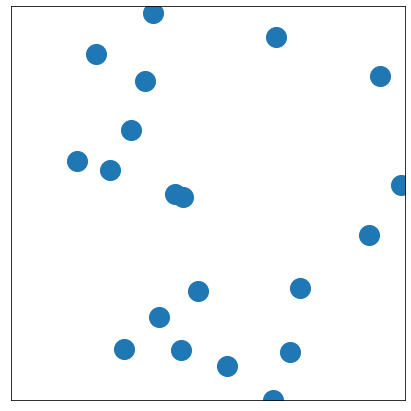

In [5]:
N = 20
dimension = 3
box_size = 12.0

key, split = random.split(key)
R = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64) 

plot_system(R,box_size)

In [6]:
box = jnp.eye(dimension) * box_size
displacement, shift = space.periodic_general(box, fractional_coordinates=False)

In [7]:
species = onp.concatenate([onp.zeros(N//2), onp.ones(N-(N//2))])
rng = onp.random.default_rng()
rng.shuffle(species)
species = jnp.asarray(species, dtype=jnp.int16)
# print(species)
jnp.max(species)

DeviceArray(1, dtype=int16)

## Potential

### Stillinger Weber

In [8]:
from jax_md.energy import stillinger_weber_neighbor_list

In [9]:
nfsw, efsw = stillinger_weber_neighbor_list(displacement, box_size, cutoff=5.5)
nbrssw = nfsw.allocate(R)
efsw = jit(efsw)

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [10]:
efsw(R, nbrssw)

DeviceArray(81.25465588, dtype=float64)

### UF3 3-body potential

In [11]:
from uf3.jax.potentials import uf3_neighbor

nf3, ef3 = uf3_neighbor(displacement,box_size ,knots=[knots2, knots3])
nbrs3 = nf3.allocate(R)

ef3 = jit(ef3)

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [12]:
print(ef3(R, neighbor=nbrs3, coefficients=[coefficients2, coefficients3]))

11674.077401136561


In [13]:
grad(ef3)(R, neighbor=nbrs3, coefficients=[coefficients2, coefficients3])

DeviceArray([[ 4.01682227e+02,  8.43966898e+01,  1.45776718e+02],
             [ 4.43079509e+02,  5.75442110e+02,  2.41872737e+02],
             [-4.59738385e+01, -3.44123536e+02, -1.08846730e+02],
             [ 4.58034244e+01, -6.50252574e+02,  1.61338654e+02],
             [ 2.80840943e+02, -3.99540825e+02, -9.37696186e+02],
             [ 6.62372745e+02, -7.48121920e+02, -8.34672899e+01],
             [ 3.40141380e+02, -1.81094293e+02,  1.96396547e+02],
             [ 9.92628692e+01, -3.53652674e+02, -4.76664220e+02],
             [-5.07302160e+01,  7.45785647e+01,  7.36968166e+02],
             [-3.14196624e+02,  1.25428555e+01,  8.74866001e+01],
             [ 1.21891733e+02, -2.59744628e+02, -3.42864904e+02],
             [-1.57335192e+01,  9.25124753e+01,  8.73129688e+01],
             [ 2.91911032e+02,  4.45350074e+02,  2.81659065e+01],
             [ 1.86722224e+02,  2.41624419e+02,  1.12172884e+02],
             [-1.27850832e+03,  9.18600812e+02,  8.69686477e+02],
          

### Dictionaies for UF potentials with species.

In [14]:
coeff_dict = {}
coeff_dict[(0,0)] = coefficients2
coeff_dict[(0,1)] = coefficients2
coeff_dict[(1,1)] = coefficients2

knot_dict = {}
knot_dict[(0,0)] = knots2
knot_dict[(0,1)] = knots2
knot_dict[(1,1)] = knots2

c3 = {}
c3[(0,0,0)] = coefficients3
c3[(0,0,1)] = coefficients3
c3[(0,1,1)] = coefficients3
c3[(1,0,0)] = coefficients3
c3[(1,0,1)] = coefficients3
c3[(1,1,1)] = coefficients3

k3 = {}
k3[(0,0,0)] = knots3
k3[(0,0,1)] = knots3
k3[(0,1,1)] = knots3
k3[(1,0,0)] = knots3
k3[(1,0,1)] = knots3
k3[(1,1,1)] = knots3

### UF 3-body potential with species

In [15]:
nf3s, ef3s = uf3_neighbor(displacement, box_size, species=species, knots=[knot_dict, k3])
nbrs3s = nf3s.allocate(R)
ef3s = jit(ef3s)

In [16]:
print(ef3s(R, neighbor=nbrs3s, coefficients=[coeff_dict, c3]))

11674.077401136561


### UF 2-body potential

In [17]:
nf2, ef2 = uf3_neighbor(displacement, box_size, knots=[knots2])
nbrs2 = nf2.allocate(R)
ef2 = jit(ef2)

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [18]:
print(ef2(R, neighbor=nbrs2, coefficients=[coefficients2]))

2265.697114062089


In [19]:
grad(ef2)(R, neighbor=nbrs2, coefficients=[coefficients2])

DeviceArray([[-2.27883014e+00, -4.72150039e+01, -5.84282055e+01],
             [-2.24835363e+01, -4.28973529e+01,  2.59606624e+01],
             [ 3.76645132e+01,  1.13648609e+01,  3.61893586e-01],
             [ 1.71114711e+01,  7.16545413e+01, -2.57058101e+00],
             [ 5.46932536e+01,  1.44704424e+01, -7.36509742e+01],
             [ 4.08410738e+01,  1.26787405e+00,  1.06425865e+01],
             [-9.02120826e+00, -2.25434833e+01,  6.22461032e+00],
             [-1.36178289e+02, -3.04513265e+01,  1.21012591e+02],
             [-1.23703597e+01, -2.95459150e+00,  6.27338035e+01],
             [ 3.49635776e+00,  1.98418157e+01, -9.13149246e+00],
             [-6.58231550e+00, -2.59505467e+01, -2.65969247e+01],
             [-2.16713954e+01, -3.42970340e+01,  5.70560892e+01],
             [-2.38680126e+01,  5.29958077e+01,  5.12982874e+01],
             [-4.52785917e+00, -5.72668861e+01,  6.41545789e+00],
             [-1.78947950e+01,  1.07861844e+02, -7.46100437e+00],
          

### UF 2-body potential with species

In [20]:
nf2s, ef2s = uf3_neighbor(displacement, box_size, species=species, knots=[knot_dict])
nbrs2s = nf2s.allocate(R)
ef2s = jit(ef2s)

In [21]:
print(ef2s(R, neighbor=nbrs2s, coefficients=[coeff_dict]))

2265.697114062089


### UF 2-body potential with featurization

In [16]:
nf2f, ef2f = uf3_neighbor(displacement, box_size, knots=[knots2], featurization=True, force_features=True)
nbrs2f = nf2f.allocate(R[:50])
ef2f = jit(ef2f)

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [17]:
ef2f(R[:50], neighbor=nbrs2f, coefficients=[coefficients2]).shape

(20, 56)

### UF 3-body potential with featurization

In [12]:
nf3f, ef3f = uf3_neighbor(displacement,box_size ,knots=[knots2, knots3], featurization=True, force_features=True)
nbrs3f = nf3f.allocate(R[:50])

ef3f = jit(ef3f)

In [13]:
a, b = ef3f(R[:50], neighbor=nbrs3f, coefficients=[coefficients2, coefficients3])
print(a.shape)
print(b.shape)

(20, 56)
(20, 1664)


## Benchmarks

(On an old CPU)

In [24]:
%%timeit
efsw(R, nbrssw)

57.5 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%%timeit
ef2(R, neighbor=nbrs2, coefficients=[coefficients2]).block_until_ready()

5.92 ms ± 27.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%%timeit
ef2s(R, neighbor=nbrs2s, coefficients=[coeff_dict]).block_until_ready()

9.87 ms ± 28.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
%%timeit
ef3(R, neighbor=nbrs3, coefficients=[coefficients2, coefficients3]).block_until_ready()

2 s ± 3.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%timeit
ef3s(R, neighbor=nbrs3s, coefficients=[coeff_dict, c3]).block_until_ready()

4.61 s ± 4.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
